## Neural networks for segmentation

In [3]:
#!S:bash
!wget https://www.dropbox.com/s/jy34yowcf85ydba/data.zip?dl=0 -O data.zip
!unzip -q data.zip

"wget" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


^C


In [4]:
import torch.nn as nn
import torch.nn.functional as F
import torch
from imgaug import augmenters as iaa


In [5]:
def aug_img(img):
    seq = iaa.Sequential([iaa.CropToFixedSize(width=32, height=32 ), 
                     iaa.MultiplyAndAddToBrightness(add=(-30, 30))])
    aug_ims, aug_heats = seq(images=[im], heatmaps=[mask.astype(np.float32).reshape(512,512,1)])

Your next task is to train neural network to segment cells edges.

Here is an example of input data with corresponding ground truth:

In [6]:
import scipy as sp
import scipy.misc
import matplotlib.pyplot as plt
import numpy as np
import skimage.io
import skimage
import copy
%matplotlib inline

In [7]:
import cv2
import glob

imdir = 'BBBC018_v1_images-fixed/train/'
ext = ['png', 'jpg', 'gif', 'bmp']    # Add image formats here

files = sorted(glob.glob(imdir + '*.' + 'bmp'))

images_train = [skimage.img_as_ubyte(skimage.io.imread(file)).astype(np.uint8) for file in files]

In [8]:
imdir = 'BBBC018_v1_outlines/train/'
ext = ['png', 'jpg', 'gif', 'bmp']    # Add image formats here

files = sorted(glob.glob(imdir + '*.' + 'png'))

masks_train = [skimage.img_as_ubyte(skimage.io.imread(file)).reshape(512, 512, 1).astype(np.float32) for file in files]

for mask in masks_train:
    mask //= 255

masks_train = masks_train

In [9]:
imdir = 'BBBC018_v1_images-fixed/val/'
ext = ['png', 'jpg', 'gif', 'bmp']    # Add image formats here

files = sorted(glob.glob(imdir + '*.' + 'bmp'))

images_val = [skimage.img_as_ubyte(skimage.io.imread(file)).astype(np.uint8) for file in files]

In [10]:
imdir = 'BBBC018_v1_outlines/val/'
ext = ['png', 'jpg', 'gif', 'bmp']    # Add image formats here

files = sorted(glob.glob(imdir + '*.' + 'png'))

masks_val = [skimage.img_as_ubyte(skimage.io.imread(file)).reshape(512, 512, 1).astype(np.float32) for file in files]
for mask in masks_val:
    mask //= 255
    
masks_val = masks_val

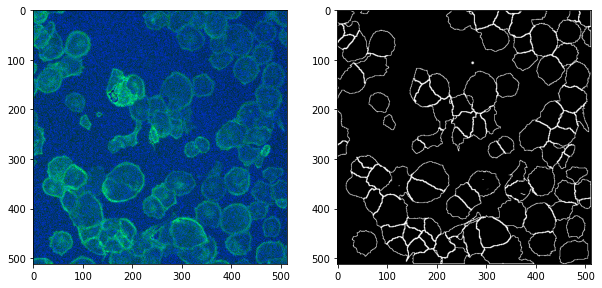

In [11]:
# Human HT29 colon-cancer cells
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
im = skimage.img_as_ubyte(skimage.io.imread('BBBC018_v1_images-fixed/train/00735-actin.DIB.bmp'))
plt.imshow(im)
plt.subplot(1,2,2)
mask = skimage.img_as_ubyte(skimage.io.imread('BBBC018_v1_outlines/train/00735-cells.png'))
plt.imshow(mask, 'gray')

This time you aren't provided with any code snippets, just input data and target metric - intersection-over-union (IoU) (see implementation below).

You should train neural network to predict mask of edge pixels (pixels in gt images with value greater than 0).

Use everything you've learnt by now: 
* any architectures for semantic segmentation (encoder-decoder like or based on dilated convolutions)
* data augmentation (you will need that since train set consists of just 41 images)
* fine-tuning

You're not allowed to do only one thing: to train you network on test set.

Your final solution will consist of an ipython notebook with code (for final network training + any experiments with data) and an archive with png images with network predictions for test images (one-channel images, 0 - for non-edge pixels, any non-zero value for edge pixels).

Forestalling questions about baseline... well, let's say that a good network should be able to segment images with iou >= 0.29. This is not a strict criterion of full points solution, but try to obtain better numbers.

Practical notes:
* There is a hard data class imbalance in dataset, so the network output will be biased toward "zero" class. You can either tune the minimal probability threshold for "edge" class, or add class weights to increase the cost of edge pixels in optimized loss. You also can try to use softIoU or DICE loss.
* Dataset is small so actively use data augmentation: rotations, flip, random contrast and brightness
* Better spend time on experiments with neural network than on postprocessing tricks (i.e test set augmentation).
* Keep in mind that network architecture defines receptive field of pixel. If the size of network input is smaller than receptive field of output pixel, than probably you can throw some layers without loss of quality. It is ok to modify "of-the-shelf" architectures. 

Good luck!

In [152]:
train_width=50
trina_height = 50
def multiply_images(imges, masks):
    seq = iaa.Sequential([
                iaa.CropToFixedSize(width=train_width, height=trina_height), 
                iaa.Sometimes(p=0.5, then_list=[iaa.MultiplyAndAddToBrightness(add=(-30, 30))])
    ])
    
    aug_ims, aug_heats = [], []
    
    for _ in range(100):
        first, second = seq(images=imges, heatmaps=masks)
        aug_ims += first
        aug_heats += second
            
    return aug_ims, aug_heats
        

In [145]:
auged_images_train, auged_masks_train = multiply_images(images_train, masks_train)

In [146]:
def calc_iou(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).sum() 
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).sum()
    return float(intersection) / union

In [147]:
    
def create_network():
    net = nn.Sequential()
    net.add_module('conv1_1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, bias=False, 
                                     dilation=1, padding=1))
    net.add_module('bn1_1', nn.BatchNorm2d(num_features=32))
    net.add_module('relu1_1', nn.ReLU(inplace=True))
    net.add_module('conv1_2', nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, bias=False, padding=1))
    net.add_module('bn1_2', nn.BatchNorm2d(num_features=32))
    net.add_module('relu1_2', nn.ReLU(inplace=True))
    net.add_module('mp1', nn.MaxPool2d(kernel_size=3, stride=1, padding=1))

    net.add_module('conv2_1', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, 
                                        dilation=1, bias=False, padding=1))
    net.add_module('bn2_1', nn.BatchNorm2d(num_features=64))
    net.add_module('relu2_1', nn.ReLU(inplace=True))
    net.add_module('conv2_2', nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, 
                                        dilation=1, bias=False, padding=1))
    net.add_module('bn2_2', nn.BatchNorm2d(num_features=64))
    net.add_module('relu2_2', nn.ReLU(inplace=True))
    net.add_module('mp2', nn.MaxPool2d(kernel_size=3, stride=1, dilation=1, padding=1))

    net.add_module('conv3_1', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, 
                                        dilation=1, bias=False, padding=1))
    net.add_module('bn3_1', nn.BatchNorm2d(num_features=128))
    net.add_module('relu3_1', nn.ReLU(inplace=True))
    net.add_module('conv3_2', nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, 
                                        dilation=1, bias=False, padding=1))
    net.add_module('bn3_2', nn.BatchNorm2d(num_features=128))
    net.add_module('relu3_2', nn.ReLU(inplace=True))
    net.add_module('mp3', nn.MaxPool2d(kernel_size=3, stride=1, dilation=1, padding=1))
    
    net.add_module('conv4_1', nn.Conv2d(in_channels=128, out_channels=1, kernel_size=1, 
                                        dilation=1, bias=False, padding=0))
#     net.add_module('fc1_bn', nn.BatchNorm2d(num_features=512))
#     net.add_module('fc1_relu', nn.ReLU(inplace=True))
#     net.add_module('conv4_1', nn.Conv2d(in_channels=512, out_channels=1, kernel_size=1, 
#                                         bias=False, padding=1))
    net.add_module('probs', nn.Sigmoid())
    
    net = net.train(False)
    return net

def preproces(patches):
    patches = patches.astype(np.float32)
    patches = patches / 255 - 0.5
    patches = patches.transpose(0,3,1,2)
    return patches

def apply_net(input_data, net):
    input_data = Variable(torch.FloatTensor(input_data))
    output = net(input_data).data.numpy()
    return output

In [148]:
#PyTorch
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

In [149]:
def get_batches(X, Y, batch_size):
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

In [153]:
def compute_loss(X_batch, y_batch, positive_class_weight=10.):
    X_batch = torch.FloatTensor(X_batch.reshape(-1, 3, train_width, trina_height)).to(device=device)
    y_batch = torch.LongTensor(y_batch.reshape(-1, 1, train_width, trina_height)).to(device=device)
    logits = net.to(device)(X_batch)
 #   logits = torch.cat([ 1 - logits, logits], dim=1)
    target = y_batch.squeeze(1)
    loss_function = DiceLoss(weight=torch.tensor([1., positive_class_weight]))
    return loss_function(logits, target).mean()

In [154]:
net = create_network()

if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
net.to(device)
device

import numpy as np

opt = torch.optim.Adam(net.parameters(), lr=0.001)

train_loss = []
val_accuracy = []

nets = []

num_epochs = 50 # total amount of full passes over training data

import time

batch_size_train = 8
batch_size_val = 1

for epoch in range(num_epochs):
    start_time = time.time()
    net.train(True) # enable dropout / batch_norm training behavior
    batch_num = 0
    for (X_batch, y_batch) in get_batches(np.array(auged_images_train), np.array(auged_masks_train), batch_size_train):
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.cpu().data.numpy())
        batch_num += 1
        if batch_num % 200 == 0:
            print('batch_num is', batch_num)
    
    net.train(False) # disable dropout / use averages for batch_norm
    
    nets.append(copy.deepcopy(net))
    
    for X_batch, y_batch in get_batches(np.array(images_val).reshape(-1, 3, 512, 512), np.array(masks_val).reshape(-1, 1, 512, 512), batch_size_val):
        logits = net(torch.FloatTensor(X_batch))
        y_pred = logits > 0.5
        val_accuracy.append(calc_iou(y_pred, y_batch))

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(auged_images_train) // batch_size :])))
    print("  val  (in-iteration): \t{:.6f}".format(
        np.mean(val_accuracy[-len(auged_images_train) // batch_size :])))

E:\MaxShit\deep_env\lib\site-packages\torch\nn\functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


batch_num is 200
batch_num is 400
Epoch 1 of 50 took 83.203s
  training loss (in-iteration): 	0.915349
  val  (in-iteration): 	0.052988
batch_num is 200
batch_num is 400
Epoch 2 of 50 took 82.245s
  training loss (in-iteration): 	0.918033
  val  (in-iteration): 	0.053572
batch_num is 200


KeyboardInterrupt: 

In [135]:
for (X_batch, y_batch) in get_batches(np.array(auged_images_train), np.array(auged_masks_train), batch_size_train):
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.cpu().data.numpy())
        batch_num += 1
        if batch_num % 200 == 0:
            print('batch_num is', batch_num)

batch_num is 200


KeyboardInterrupt: 

In [ ]:
X

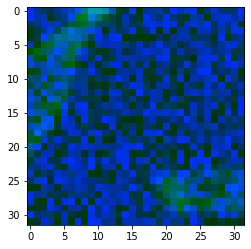

In [142]:
plt.imshow(X_batch[5].reshape(32,32, 3))

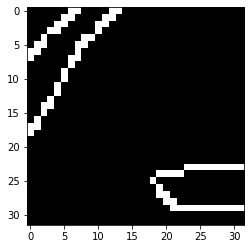

In [143]:


plt.imshow(y_batch[5].reshape(32,32), 'gray')


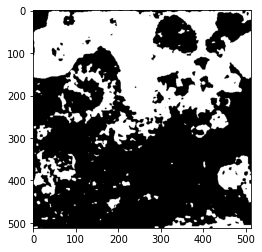

In [122]:
plt.imshow(y_pred[5].reshape(512,512), 'gray')

In [50]:
X_batch = torch.FloatTensor(X_batch.reshape(-1, 3, 32, 32)).to(device=device)
y_batch = torch.LongTensor(y_batch.reshape(-1, 1, 32, 32)).to(device=device)
logits = net.to(device)(X_batch)
logits = torch.cat([ 1 - logits, logits], dim=1)
target = y_batch.squeeze(1)
loss_function = nn.NLLLoss(weight=torch.tensor([1., 50.]))
loss_function(logits, target).mean()

tensor(-0.2532, grad_fn=<MeanBackward0>)

In [44]:
logits[0,0,0,1]

torch.Tensor

In [28]:
y_batch.shape

torch.Size([28, 1, 32, 32])

In [23]:
y_batch

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 1., 1., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.

In [17]:
n_images = len(prediction)
intersection, union = 0, 0
for i in range(n_images):
    intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).sum() 
    union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).sum()
return float(intersection) / union

NameError: name 'prediction' is not defined

In [137]:
X_batch = torch.FloatTensor(X_batch.reshape(batch_size, 3, 32, 32)).to(device=device)
y_batch = torch.FloatTensor(y_batch.reshape(batch_size, 1, 32, 32)).to(device=device)
logits = net.to(device)(X_batch)
F.binary_cross_entropy(logits, y_batch).mean()

tensor(0.3760, grad_fn=<MeanBackward0>)

In [133]:
torch.cat([1-logits, logits], dim=1).shape

torch.Size([28, 2, 32, 32])

In [128]:
y_batch.shape

torch.Size([28, 1, 32, 32])

In [91]:
torch.FloatTensor(X_batch).shape

torch.Size([28, 32, 32, 3])

In [52]:
auged_images_train.astype(np.uint8)

ValueError: setting an array element with a sequence.

In [80]:
torch.FloatTensor(np.array(auged_images_train).astype(np.uint8))

/root/venvs/deep_lerning/lib/python3.6/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


ValueError: setting an array element with a sequence.

In [78]:
auged_images_train

[array([[[ 72, 255, 192],
         [ 14,  14,  21],
         [ 17,  33,  25],
         ...,
         [ 32, 188,  98],
         [ 36, 217,  85],
         [ 44, 250, 183]],
 
        [[ 77, 255, 255],
         [ 16,  25,  24],
         [ 30,  79, 253],
         ...,
         [ 38, 194, 255],
         [ 37, 201, 150],
         [ 37, 227,  78]],
 
        [[ 16,  17, 125],
         [ 22,  55, 104],
         [ 38, 138, 251],
         ...,
         [ 37, 185, 255],
         [ 35, 184, 216],
         [ 34, 197,  82]],
 
        ...,
 
        [[ 18,  66, 192],
         [ 18,  67, 184],
         [ 18,  74, 117],
         ...,
         [ 30, 171, 105],
         [ 27, 127, 255],
         [ 23, 113, 131]],
 
        [[ 14,  71,  31],
         [ 19,  68, 225],
         [ 16,  65, 131],
         ...,
         [ 18, 100,  17],
         [ 25, 100, 255],
         [ 20,  85, 194]],
 
        [[ 20,  69, 252],
         [ 20,  69, 255],
         [ 14,  71,  38],
         ...,
         [ 22,  78, 255],
  